# 2D SEIR Dorm Intervention Model
A simulation of a 2D college dorm that demonstrates infection and intervention dynamics.<br><br>
Each student is represented by an agent. Given an initial infected population, and agents characterized on a scale of "risk", the goal of this simulation is to demonstrate how agents with different "risk" behaviors affect the infection dynamics in a college dorm setting. The hope is to prove the effectiveness of ABM-modeling in understanding the efficacy of public health interventions.

In [48]:
#imports 
using Agents
using CairoMakie
using Random
using Plots
using Makie

## Model Description

### Agent Description

In [26]:
@agent struct Student(GridAgent{2})
    health_status::Int  # 1: Susceptible, 2: Exposed, 3: Infected, 4: Recovered
    days_exposed::Int   # How long an agent has been exposed
    days_infected::Int  # How long an agent has been infected
    risk_class::Int     # 0 = no precautions, 1 = masked, 2 = vaccinated
end

### Agent State Transition Function
This function updates the state of an individual agent in the model to the next timestep.

In [84]:
function student_step!(agent, model)
    global wall_positions
    global door_positions

    if agent.health_status == 1  # If the agent is susceptible

        # If agent is masked (risk_class = 1), apply mask benefit
        if agent.risk_class == 1
            effective_trans_prob = transmission_prob * (1-masking_benefit)
        # If agent is vaccinated (risk_class = 2), apply vaccine benefit
        elseif agent.risk_class == 2
            effective_trans_prob = transmission_prob * (1-vaccine_benefit)
        # Otherwise, fix standard transmission probability
        else
            effective_trans_prob = transmission_prob
        end

        for neighbor in nearby_agents(agent, model)

            if neighbor.health_status == 3  # If neighbor is infected
                if rand() < effective_trans_prob
                    agent.health_status = 2  # Move to exposed state
                    agent.days_exposed = 0  # Start tracking exposure time
                    break
                end
            end
        end

    elseif agent.health_status == 2  # If the agent is exposed

        agent.days_exposed += 1  # Increase exposure duration

        if agent.days_exposed >= d_exposure
            if rand() < transmission_prob  # If exposed agent becomes infected
                agent.health_status = 3  # Becomes infected
                agent.days_infected = 0
            else
                agent.health_status = 1  # Returns to susceptible if not infected
            end
        end

    elseif agent.health_status == 3  # If the agent is infected

        agent.days_infected += 1  # Increase infection duration
        
        if agent.days_infected >= d_infected
            agent.health_status = 4  # Transition to recovered
        end
    end

    # Random walk with wall and door constraints
    possible_moves = [(agent.pos[1] + dx, agent.pos[2] + dy) for dx in -1:1 for dy in -1:1 if abs(dx) + abs(dy) == 1]
    possible_moves = filter(p -> 1 <= p[1] <= 20 && 1 <= p[2] <= 20 && p ∉ wall_positions, possible_moves)

    # Allow movement through doors
    possible_moves = filter(p -> p ∉ wall_positions || p ∈ door_positions, possible_moves)

    # Function to check if a position is occupied
    function is_position_occupied(pos, model)
        for a in allagents(model)
            if a.pos == pos
                return true
            end
        end
        return false
    end
    
    # Choose a random move that is not a wall and is empty
    empty_moves = filter(p -> !is_position_occupied(p, model), possible_moves)
    if !isempty(empty_moves)
        new_pos = rand(empty_moves)
        agent.pos = new_pos # Update the agent's position directly
    end
end

student_step! (generic function with 1 method)

### Model Initialization

In [251]:
function initialize(;grid_size=20, d_infected=8)
    space = GridSpaceSingle((grid_size, grid_size); periodic = false)
    scheduler = Schedulers.ByProperty(:health_status)

    global wall_positions = Set{NTuple{2, Int}}()
    global door_positions = Set{NTuple{2, Int}}()

    hallway_width = 8.5
    inner_min = hallway_width
    inner_max = grid_size - hallway_width

    # Build outer hallway walls (a square path around center)
    for x in 1:grid_size
        for y in 1:grid_size
            if (inner_min <= x <= inner_max) && (inner_min <= y <= inner_max)
                push!(wall_positions, (x, y))  # fill in the middle
            end
        end
    end

    # Carve out hallway ring by removing inner edge of hallway
    for x in (inner_min + 1):(inner_max - 1)
        for y in (inner_min + 1):(inner_max - 1)
            delete!(wall_positions, (x, y))
        end
    end

    # Make rooms
    for y in 1:20
        push!(wall_positions, (5, y))
        push!(wall_positions, (15, y))
    end

    for x in 1:5
        push!(wall_positions, (x, 6))
        push!(wall_positions, (x, 14))
    end

    for x in 15:20
        push!(wall_positions, (x, 6))
        push!(wall_positions, (x, 14))
    end

    # Make doors
    push!(door_positions, (5, 3))
    push!(door_positions, (5, 10))
    push!(door_positions, (5, 17))
    push!(door_positions, (15, 3))
    push!(door_positions, (15, 10))
    push!(door_positions, (15, 17))
    
    properties = Dict(
        :wall_positions => wall_positions,
        :door_positions => door_positions,
    )

    # Initialize model 
    model = StandardABM(
        Student, 
        space;
        agent_step! = student_step!,
        scheduler,
        properties = properties,
        container = Vector,
    )

    # Available positions: NOT walls, NOT in center hallway
    available_positions = Set{NTuple{2, Int}}()
    for x in 1:grid_size
        for y in 1:grid_size
            if (x, y) ∉ wall_positions && !((inner_min ≤ x ≤ inner_max) && (inner_min ≤ y ≤ inner_max))
                push!(available_positions, (x, y))
            end
        end
    end

    # Risk group assignments
    n_masked = round(Int, p_masked * healthy_population)
    n_vaccinated = round(Int, p_vaccinated * healthy_population)
    n_at_risk = healthy_population - n_masked - n_vaccinated

    # Error checking - valid assignment of intervention populations?
    if (p_masked + p_vaccinated) > 1
        println("Invalid assignment of masked/vaccinated proportions.")
        return nothing
    end

    # Randomize risk classes among agents
    risk_classes = vcat(fill(1, n_masked), fill(2, n_vaccinated), fill(0, n_at_risk))
    shuffle!(risk_classes)
    
    # Place healthy agents
    for n in 1:healthy_population
        if !isempty(available_positions)
            pos = pop!(available_positions)
            rc = risk_classes[n]
            add_agent_single!(model; health_status=1, days_exposed=-1, days_infected=-1, risk_class=rc, pos=pos)
        else
            println("Error! Too many agents for the space.")
            break
        end
    end

    # Place infected agents
    for i in 1:sick_population
        if !isempty(available_positions)
            pos = pop!(available_positions)
            # Randomize days_infected between 0 and d_infected - 1 (which is 7)
            days_infected = rand(0:(d_infected-1))
            add_agent_single!(model; health_status=3, days_exposed=-1, days_infected=days_infected, risk_class=0, pos=pos)
        else
            println("Not enough space for infected agents.")
            break
        end
    end

    return model
end

initialize (generic function with 1 method)

### Population Plotting Functions
This function plots SEIR populations over time.

In [213]:
function pop_plot(timesteps, susceptible_count, exposed_count, infected_count, recovered_count)
    fig = Figure()
    ax = Axis(fig[1, 1], xlabel="Time (Days)", ylabel="Number of Agents", title="Infection Spread Over Time", yticks = 0:20:90)

    lines!(ax, 1:timesteps, susceptible_count, label="Susceptible", color=:blue)
    lines!(ax, 1:timesteps, exposed_count, label="Exposed", color=:orange)
    lines!(ax, 1:timesteps, infected_count, label="Infected", color=:red)
    lines!(ax, 1:timesteps, recovered_count, label="Recovered", color=:green)

    axislegend(ax)
    Makie.ylims!(0, 90)    
    display(fig)
    Makie.save("seir.png", fig)
end


pop_plot (generic function with 1 method)

This function plots infected populations by risk class (0 = unprotected, 1 = masked, 2 = vaccinated).

In [241]:
function plot_infected_by_risk(infected_by_risk)
    timesteps = size(infected_by_risk, 1)
    ts = 1:timesteps

    fig = Figure()
    ax = Axis(
        fig[1, 1],
        xlabel = "Time (Days)",
        ylabel = "Infected Count",
        title = "Infected Over Time by Risk Class",
        yticks = 0:5:25
    )

    lines!(ax, ts, infected_by_risk[:, 1], label="At Risk", color=:red, linewidth=2)
    lines!(ax, ts, infected_by_risk[:, 2], label="Masked", color=:orange, linewidth=2)
    lines!(ax, ts, infected_by_risk[:, 3], label="Vaccinated", color=:green, linewidth=2)

    Makie.ylims!(ax, 0, 25)
    axislegend(ax, position = :rt)
    display(fig)
    Makie.save("infected.png", fig)
end

plot_infected_by_risk (generic function with 1 method)

## Simulation Code

In [ ]:
function run(timesteps)
    # Track total SEIR counts over time
    state_counts = []

    # Track infected by risk class: infected_by_risk[t][r+1] = infected count for risk r at timestep t
    infected_by_risk = []

    # Initialize model
    model = initialize()

    # Save initial state as an image
    figure_1, _ = abmplot(model; agent_color = groupcolor, agent_marker = groupmarker, agent_size = 10,heatarray=wall_heatmap,heat_kwargs=(colormap=:grays, colorrange=(0, 1)))
    Makie.save("start.png", figure_1)

    if model == nothing
        return model
    end

    for t in 1:timesteps
        for agent in allagents(model)
            student_step!(agent, model)
        end

        # Total SEIR counts
        susceptible_count = count(a -> a.health_status == 1, allagents(model))
        exposed_count     = count(a -> a.health_status == 2, allagents(model))
        infected_count    = count(a -> a.health_status == 3, allagents(model))
        recovered_count   = count(a -> a.health_status == 4, allagents(model))
        push!(state_counts, [susceptible_count, exposed_count, infected_count, recovered_count])

        # Infected counts by risk class
        infected_risk = [
            count(a -> a.health_status == 3 && a.risk_class == risk, allagents(model))
            for risk in 0:2
        ]
        push!(infected_by_risk, infected_risk)
    end
    # Save end state as an image
    figure_1, _ = abmplot(model; agent_color = groupcolor, agent_marker = groupmarker, agent_size = 10,heatarray=wall_heatmap,heat_kwargs=(colormap=:grays, colorrange=(0, 1)))
    Makie.save("end.png", figure_1)
    
    return state_counts, infected_by_risk
end


run (generic function with 2 methods)

In [32]:
function run_sims(num_runs, timesteps, plot)

    sum_counts = zeros(timesteps, 4)  # SEIR totals
    sum_infected_by_risk = zeros(timesteps, 3)  # risk class 0, 1, 2

    for i in 1:num_runs
        trial_counts, trial_infected_by_risk = run(timesteps)
        if trial_counts == nothing
            print("Could not complete run.")
            return
        end
            
        for t in 1:timesteps
            sum_counts[t, :] .+= trial_counts[t]
            sum_infected_by_risk[t, :] .+= trial_infected_by_risk[t]
        end
    end

    avg_counts = sum_counts ./ num_runs
    avg_infected_by_risk = sum_infected_by_risk ./ num_runs

    if plot
        # Plot SEIR
        susceptible_data = avg_counts[:, 1]
        exposed_data     = avg_counts[:, 2]
        infected_data    = avg_counts[:, 3]
        recovered_data   = avg_counts[:, 4]
        pop_plot(timesteps, susceptible_data, exposed_data, infected_data, recovered_data)

        # Plot infected by risk class
        plot_infected_by_risk(avg_infected_by_risk)
    end
end

run_sims (generic function with 2 methods)

In [33]:
function count_risk_classes(model)
    counts = Dict(0 => 0, 1 => 0, 2 => 0)
    for agent in allagents(model)
        counts[agent.risk_class] += 1
    end
    return counts
end

count_risk_classes (generic function with 1 method)

## Run the simulation from here

Below is the main driver code for the simulation. 

In the AGENT/ENV PARAMS section, define the probabilities that govern state transitions. These include probabilities of transmission, risk/exposure, the size of the initial healthy and sick populations, and the duration of infection/exposure, etc.

In the SIM_PARAMS section, define the simulation parameters like the number of timesteps and whether graphs should be plotted or not.

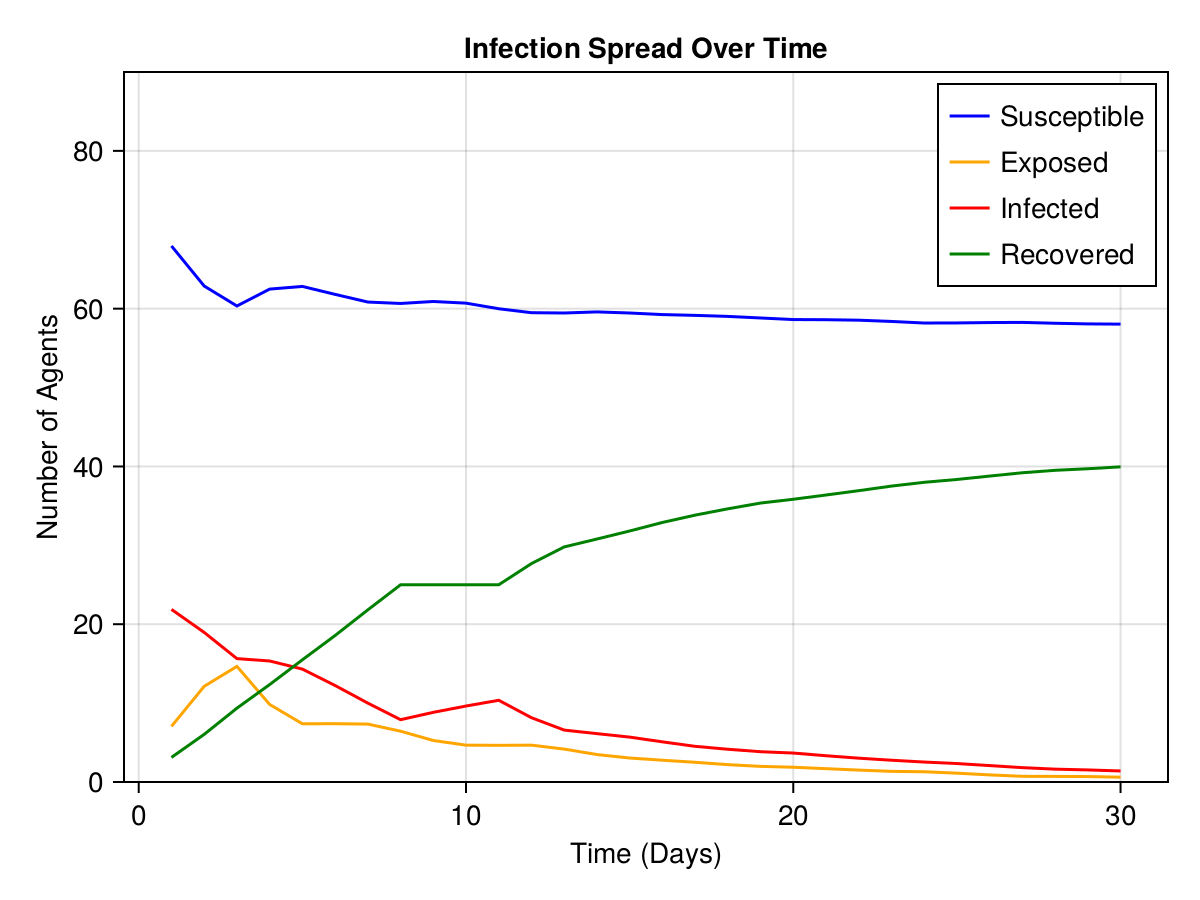

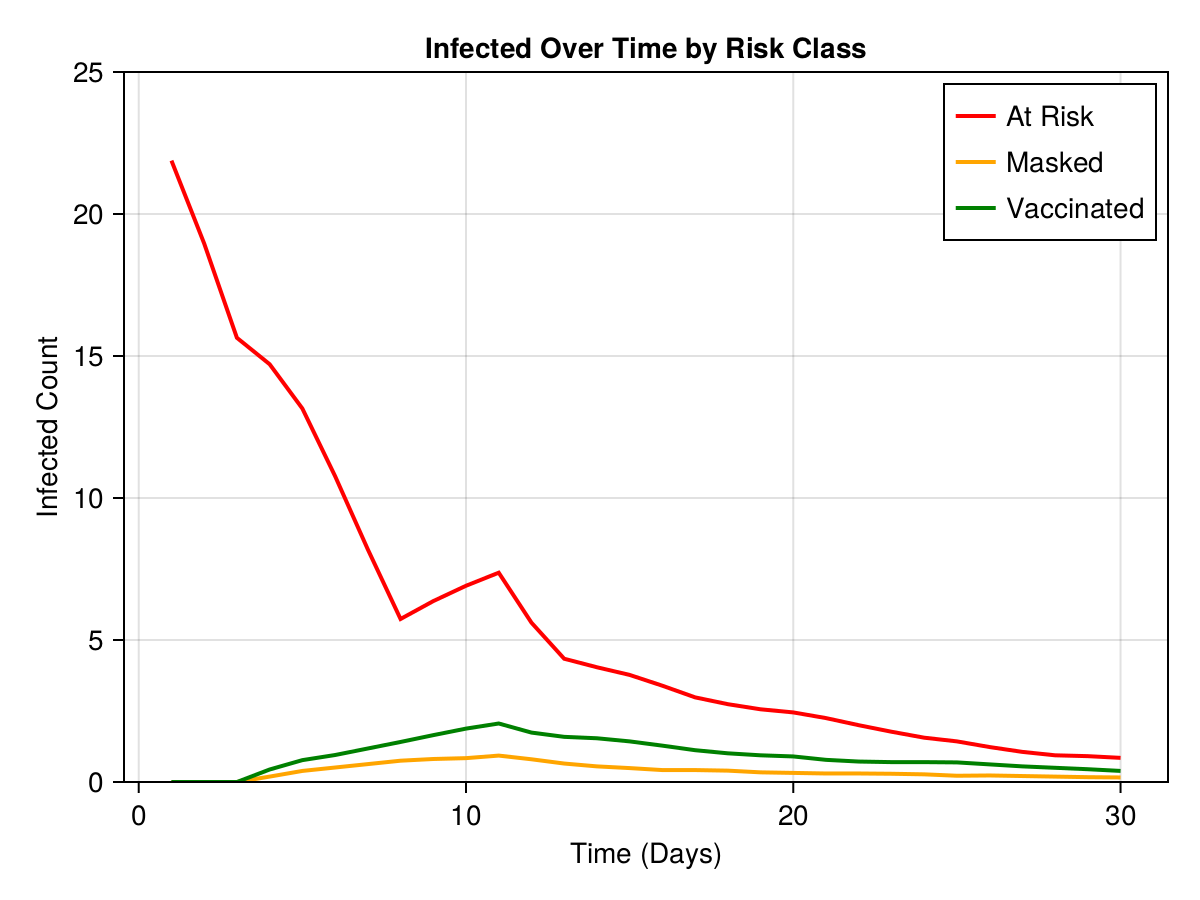

CairoMakie.Screen{IMAGE}


In [257]:
# ENV_PARAMS
transmission_prob = 0.4  # Probability of being infected when exposed
sick_population = 25 # Initial population of infected 
healthy_population = 75 # Initial population of healthy
d_infected = 8  # Duration for being infected
d_exposure = 3  # Duration for exposure before infection (or returning to susceptible)

# INTERVENTION/RISK PARAMS
masking_benefit = 0.5 # Benefit for masking is a 20% reduction in transmission_prob - corresponds to risk class 1
vaccine_benefit = 0.8 # Benefit for vaccine is a 75% reduction in transmission_prob - corresponds to risk class 12
p_masked = 0.1 # Proportion of population that is masked (e.g. 0.3 corresponds to 30% masking rate)
p_vaccinated = 0.4 # Proportion of population that is vaccinated (e.g. 0.2 corresponds to 20% vaccination rate) 

# SIM_PARAMS
timesteps = 30 # Number of days
num_runs = 100 # Number of runs - graphs/data will average over all runs
plot_graphs = true # Toggle to plot graphs

# Run
run_sims(num_runs, timesteps, plot_graphs)

## MISCELLANEOUS

Below contains work-in-progress code for testing/debugging/visualization. This section can be disregarded by users and will be excluded from the final simulation package.

In [38]:
# Function coloring 
function groupcolor(agent)
    if agent.health_status == 1
        return :blue
    elseif agent.health_status == 2
        return :yellow # Exposed agents are often yellow
    elseif agent.health_status == 3
        return :red # Infected agents are red
    elseif agent.health_status == 4
        return :green # Recovered agents are green
    end
end


function groupmarker(agent)
    if agent.health_status == 1
        return :circle
    elseif agent.health_status == 2
        return :rect
    elseif agent.health_status == 3
        return :rect # Assuming infected agents are also rectangles
    elseif agent.health_status == 4
        return :circle # Assuming recovered agents are circles
    end
end
# Create heatmap showing walls
function wall_heatmap(model)
    dims = (20,20)
    grid = fill(1.0, dims...)  # 0 = free, 1 = wall
    for (x, y) in model.wall_positions
        grid[x, y] = 0.0
    end
    for (x, y) in model.door_positions
        grid[x, y] = 1.0
    end
    return grid
end

wall_heatmap (generic function with 1 method)

In [ ]:
begin
	student_model = initialize()
	abmvideo(
    "student.mp4", student_model;
    agent_color = groupcolor, agent_marker = groupmarker, heatarray=wall_heatmap,heat_kwargs=(colormap=:grays, colorrange=(0, 1)),
    framerate = 1, frames = 7, dt = 1,
    title = "Student Infection Spread")
end

In [ ]:
# Visualize grid
student_model = initialize()
figure_1, _ = abmplot(student_model; agent_color = groupcolor, agent_marker = groupmarker, agent_size = 10,heatarray=wall_heatmap,heat_kwargs=(colormap=:grays, colorrange=(0, 1)))
figure_1

In [ ]:
step!(student_model)
figure_2, _ = abmplot(student_model; agent_color = groupcolor, agent_marker = groupmarker, agent_size = 10, heatarray=wall_heatmap,heat_kwargs=(colormap=:grays, colorrange=(0, 1)))
figure_2